In [2]:
import numpy as np
import xarray as xr
import pandas as pd

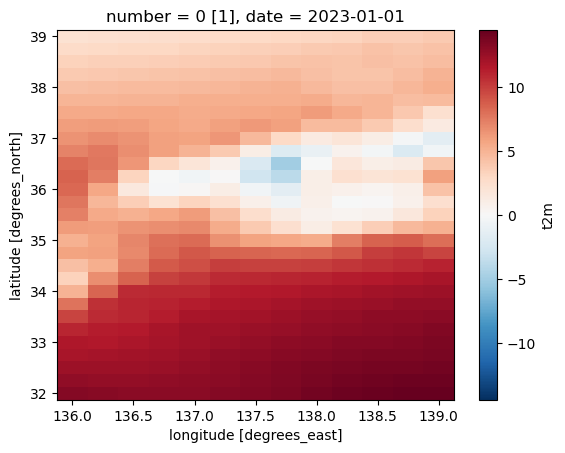

In [13]:
era5 = xr.open_dataset('/Users/doan/Downloads/same_with_NAROdata_domain (1).nc')['t2m']
lo_ds = era5.groupby('valid_time.date').mean() - 273.15 
lo_ds[0].plot()

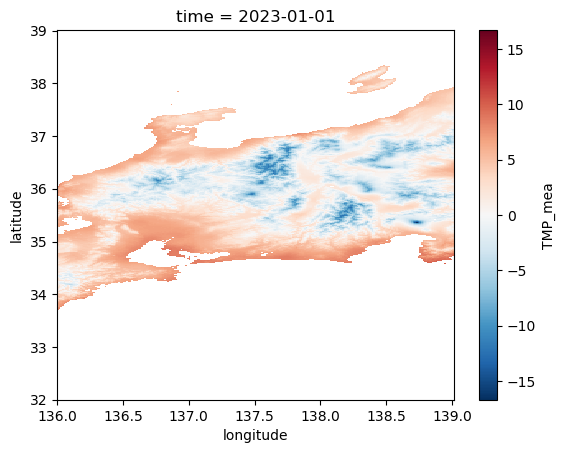

In [23]:
ds = xr.open_dataset('/Users/doan/Downloads/NARO_data2023 (1).nc')['TMP_mea']
ds[0].plot()

### Selecting Data Subset

<xarray.DataArray 'TMP_mea' (time: 365, latitude: 24, longitude: 32)> Size: 2MB
[280320 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
  * latitude   (latitude) float32 96B 36.0 36.01 36.02 ... 36.18 36.19 36.2
  * longitude  (longitude) float32 128B 136.6 136.6 136.6 ... 136.9 136.9 136.9


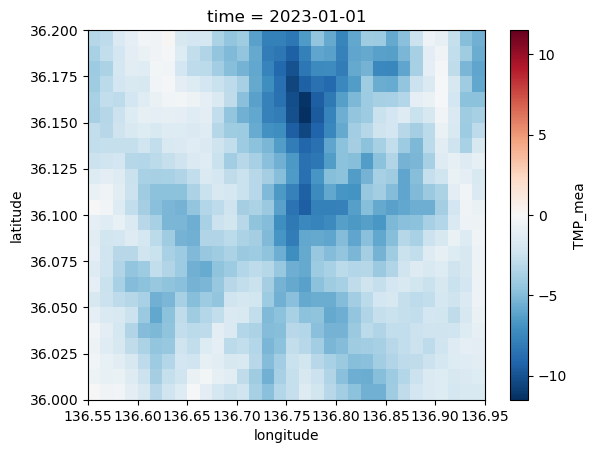

In [32]:
# Define the latitude and longitude range for data selection

# Greater Nagoya:
#latslide = (34.6, 35.6)
#lonslide = (136, 137.3)

# Nagoya area:
#latslide = (34.95, 35.15)
#lonslide = (136.55, 136.95)

# Mountain area north of Nagoya:
latslide = (36, 36.2)
lonslide = (136.55, 136.95)

# Select the dataset over the specified latitude and longitude range
hi_ds = ds.sel(latitude=slice(latslide[0], latslide[1]), longitude=slice(lonslide[0], lonslide[1]))

# Print selected dataset information
print(hi_ds)

# Plot the first timestep or data array of the selected dataset
hi_ds[0].plot()

## Regrid ERA5 to Noken:
### Interpolating Data to Match High-Resolution Coordinates

This code performs interpolation on a dataset (`lo_ds`) to align it with the coordinates of a higher-resolution dataset (`hi_ds`). This process adjusts the lower-resolution data to match the spatial resolution of the high-resolution data.

- **`lo_regridded = lo_ds.interp(latitude=hi_ds.latitude, longitude=hi_ds.longitude, method="nearest")`**:
   - Uses the `.interp()` method to interpolate `lo_ds` to match the latitude and longitude of `hi_ds`.
   - **`latitude=hi_ds.latitude`** and **`longitude=hi_ds.longitude`** specify the target coordinates for interpolation, taken from `hi_ds`.
   - **`method="nearest"`**: Sets the interpolation method to "nearest," which assigns the nearest data points in `lo_ds` to each corresponding point in `hi_ds`, ensuring a close match to the high-resolution grid.
   - The interpolated data is saved as `lo_regridded`, now aligned with the high-resolution dataset’s coordinates.

In [33]:
# Assuming 'latitude' and 'longitude' as the coordinate names in both datasets
lo_regridded = lo_ds.interp(latitude=hi_ds['latitude'], longitude=hi_ds['longitude'], method="nearest")

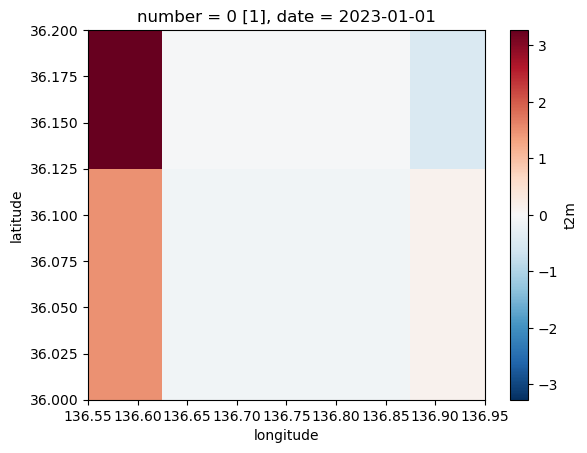

In [34]:
lo_regridded[0].plot()

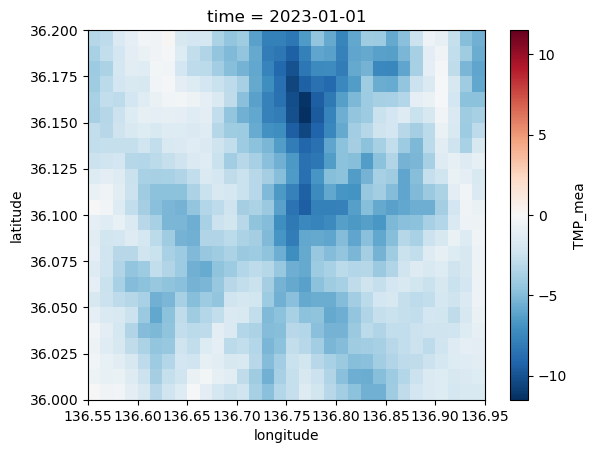

In [35]:
hi_ds[0].plot()

### Creating a Combined Dataset with High-Resolution, Low-Resolution, and Mask Data

This code creates a new xarray dataset, `do`, which combines the high-resolution (`hi`) and interpolated low-resolution (`lo`) data along with a mask to identify missing data points. This dataset structure enables side-by-side analysis of the two datasets on matching coordinates.

- **`do = xr.Dataset({'hi': (('date', 'latitude', 'longitude'), hi_ds.values), 'lo': (('date', 'latitude', 'longitude'), lo_regridded.values)})`**:
   - Initializes a new dataset `do` using `xr.Dataset`, containing two data variables:
     - **`'hi'`**: Holds the high-resolution data values from `hi_ds` with dimensions `date`, `latitude`, and `longitude`.
     - **`'lo'`**: Holds the interpolated low-resolution data values from `lo_regridded`, aligned with the same dimensions as `hi`.
  
- **`do.coords['date'] = ('date', hi_ds.time.values)`**:
   - Sets the `date` coordinate in `do` using `hi_ds.time.values`, establishing the time dimension for both `hi` and `lo` variables.
  
- **`do.coords['latitude'] = ('latitude', hi_ds.latitude.values)`** and **`do.coords['longitude'] = ('longitude', hi_ds.longitude.values)`**:
   - Sets the `latitude` and `longitude` coordinates in `do` based on `hi_ds` coordinates, ensuring both variables share the same spatial grid.

- **`do['mask'] = (("latitude", "longitude"), do.hi.isel(date=0).isnull().values)`**:
   - Creates a mask variable in `do` to indicate missing data in `hi`.
   - **`do.hi.isel(date=0).isnull().values`**: Selects the first date from `hi`, checks for `NaN` (missing) values, and stores this as a Boolean array.
   - The result is stored as `mask`, with `True` representing missing data points in `hi` and `False` representing valid data points.



 

In [19]:
do = xr.Dataset( {'hi': ( ('date', 'latitude', 'longitude'), hi_ds.values), 
                  'lo': (('date', 'latitude', 'longitude'), lo_regridded.values) } )
do.coords['date'] = ('date', hi_ds.time.values) 
do.coords['latitude'] = ('latitude', hi_ds.latitude.values) 
do.coords['longitude'] = ('longitude', hi_ds.longitude.values) 
do['mask'] = (("latitude", "longitude"), do.hi.isel(date=0).isnull().values)

### Filling Missing Values in High-Resolution Data Using Low-Resolution Data

This code fills any missing values (`NaN`) in the high-resolution data (`hi`) using the corresponding values from the low-resolution data (`lo`). This step ensures that gaps in the high-resolution dataset are supplemented by available data from the lower-resolution dataset.

- **`do['hi'] = do['hi'].fillna(do['lo'])`**:
   - Uses the `.fillna()` method on `do['hi']` to replace missing values (`NaN`) in `hi` with values from `lo`.
   - If a value in `hi` is missing at a particular date, latitude, and longitude, the corresponding value from `lo` is used to fill in the gap.
   - This operation allows the `hi` variable to be more complete by leveraging data from `lo` where `hi` has gaps.


In [37]:
do['hi'] = do['hi'].fillna(do['lo'])

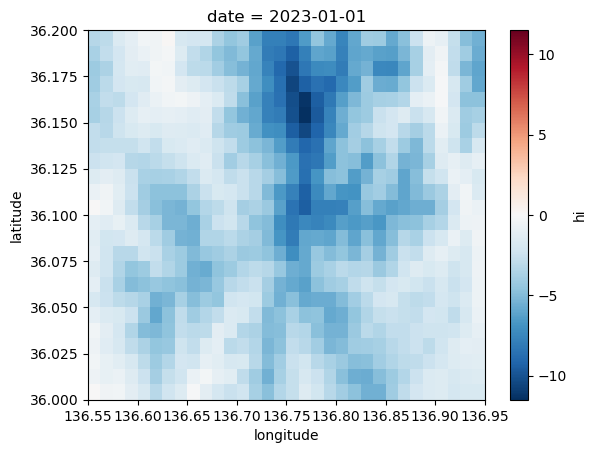

In [38]:
do['hi'][0].plot()

# Setup name of experimence

In [40]:
ename =  'north_nagoya'

In [41]:

do.to_netcdf('data/'+ename+'_input.nc')
do.close()

## Divide data into three sets

we have  365 sample


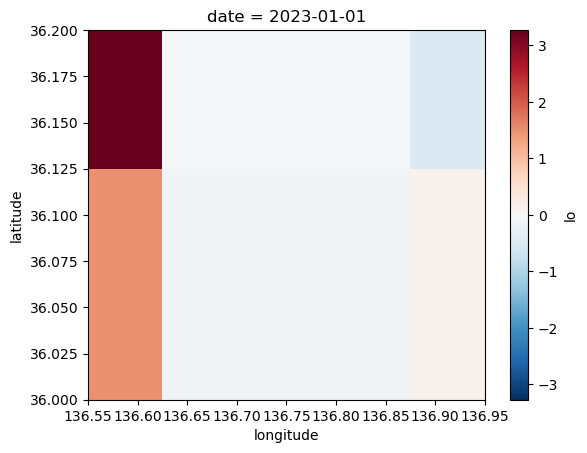

### Splitting Data into Training, Validation, and Test Sets

This code separates a dataset into three distinct parts: training, validation, and test sets. The training set is used for model training, the validation set for tuning, and the test set for final evaluation. 

#### Step-by-Step Explanation

1. **Initialize and Define Sample Indices**

   - `ii = np.arange(n)`: Creates an array 𝟸 with indices from 𝟶 to 𝑛−1, where 𝑛 is the total number of samples.
   - `n_train = int(round(.7*n))`: Calculates 𝑛_train, the number of samples for the training set, as 70% of the total data.
   - `print('extract: ', n_train, 'for training')`: Outputs the number of samples that will be used for training.

2. **Randomly Select Training Indices**

   - `import random`: Imports the random library for generating random numbers.
   - `itrain=[]`: Initializes an empty list 𝑖_train to hold indices for the training set.
   - `while len(itrain) != n_train`: Continues looping until 𝑖_train has 𝑛_train unique indices.
     - `r=random.randint(0,n-1)`: Selects a random integer 𝑟 between 𝟶 and 𝑛−1.
     - `if r not in itrain: itrain.append(r)`: Adds 𝑟 to 𝑖_train only if it’s not already in the list, ensuring unique indices.
   - `i2 = np.setdiff1d(ii, itrain)`: Computes the remaining indices, 𝑖2, by excluding 𝑖_train from the full index list 𝑖𝑖.

3. **Randomly Select Validation Indices from Remaining Data**

   - `n_vt = len(i2)`: Sets 𝑛_vt to the number of remaining samples.
   - `n_val = int(round(.6*n_vt))`: Calculates 𝑛_val, the number of samples for the validation set, as 60% of the remaining data.
   - `j1=[]`: Initializes an empty list 𝑗1 to hold validation indices.
   - `while len(j1) != n_val`: Continues looping until 𝑗1 contains 𝑛_val unique indices.
     - `r=random.randint(0, n_vt - 1)`: Selects a random integer 𝑟 between 𝟶 and 𝑛_vt−1.
     - `if r not in j1: j1.append(r)`: Adds 𝑟 to 𝑗1 only if it’s not already in the list.
   - `ival = i2[j1]`: Selects validation indices 𝑖_val from the remaining data, 𝑖2, using the indices in 𝑗1.
   - `itest = np.setdiff1d(i2, ival)`: Assigns the remaining indices to 𝑖_test, forming the test set.

4. **Verify Partition Sizes**

   - `print(np.unique(np.union1d(itrain, np.union1d(ival, itest))).shape)`: Checks that the union of all indices (𝑖_train, 𝑖_val, 𝑖_test) has the correct total sample count.
   - `print(len(itrain) + len(ival) + len(itest))`: Confirms that the combined length of 𝑖_train, 𝑖_val, and 𝑖_test matches the original number of samples, ensuring no overlaps or missing indices.

5. **Subset Data for Training, Validation, and Test Sets**

   - `dtrain0 = dinput.isel(time=itrain)`: Creates the training dataset by selecting 𝑖_train indice


In [44]:
dinput = xr.open_dataset('data/'+ename+'_input.nc')
#n = 365
n = dinput['hi'].shape[0]
print('we have ', n, 'sample')
# separate data to three part: 1) training; 2) validation; 3) test
ii = np.arange(n)
n_train = int(round(.7*n))
print('extract: ', n_train, 'for training')
import random
itrain=[]
while len(itrain) !=  n_train :
   r=random.randint(0,n-1)
   if r not in itrain: itrain.append(r)
i2 = np.setdiff1d(ii, itrain)
print('then we have remaining ', len(i2))
n_vt = len(i2)
n_val = int(round(.6*n_vt))
j1=[]
while len(j1) !=  n_val :
    r=random.randint(0, n_vt - 1)
    if r not in j1: j1.append(r)
ival = i2[j1]
itest = np.setdiff1d(i2, ival)
print(np.unique(np.union1d(itrain, np.union1d(ival, itest))).shape)
print(len(itrain) + len(ival) + len(itest))
# -
dtrain0 = dinput.isel(date=itrain)
dval0 = dinput.isel(date=ival)
dtest0 = dinput.isel(date=itest)


# =====
dtrain0.to_netcdf('data/'+ename+'_train.nc')
dval0.to_netcdf('data/'+ename+'_val.nc')
dtest0.to_netcdf('data/'+ename+'_test.nc')

extract:  255 for training
then we have remaining  110
(365,)
365
